# HY-2B SCA L2A后向散射系数投影

In [1]:
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from skimage import exposure
from RSData import *
from HaiYangData import *

import h5py
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import io
import cv2

In [2]:
def split_file_day(files):
    # 按照天来划分文件，同一天的内容在一个list里面
    file_list = []
    list = []
    for i in range(len(files)):

        if i == 0:
            list.append(files[i])
            continue

        if (files[i].split('_')[8].split('T')[0]) == (files[i-1].split('_')[8].split('T')[0]):
            list.append(files[i])
        else:
            file_list.append(list)
            list = []
            list.append(files[i])
    file_list.append(list)
    return file_list

In [3]:
def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180,bbox_inches='tight',pad_inches = 0, edgecolor = 'white')
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img



In [4]:
 def draw_sigmod_0(x_map, y_map, grid_array,save_path = None):
    fig = plt.figure(figsize=(9, 9))
    fig.add_subplot(111)
    fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

    # hy_m.fillcontinents()
    hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
    hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)
    # you can get a high-resolution image as numpy array!!
    if save_path:
        plt.savefig(save_path,dpi=180,bbox_inches='tight',pad_inches = 0, edgecolor = 'white')
    plt.close()
    
    return fig


In [5]:
satellite = r'HY2B'
sensor = r'SCA'
hy_sca = HaiYangData(satellite=satellite, sensor=sensor,resolution=25000)

# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

dir_path = r"H:\remote_sensing_data\back_scatter\HY-2B"

files = glob.glob(dir_path + '\*_pwp_250_03.h5')

file_list = split_file_day(files)

In [6]:
transformer = HaiYangData.set_transformer(crs,crs2)
transformer_back = HaiYangData.set_transformer(crs2,crs)

train_data_dir = r'E:\python_workfile\sea_ice_classification\data\train_data'

In [10]:
value_array = np.empty(shape=(1702, 810,5))
grid_array = np.zeros((hy_sca.nlat, hy_sca.nlon))
grid_num_array = np.zeros((hy_sca.nlat, hy_sca.nlon))

for file in file_list[1]:
    with h5py.File(file, mode='r') as f:
        lat = f['cell_lat'][:]
        lon = f['cell_lon'][:]
        sigma0 = f['cell_sigma0'][:]

    sigma0 = sigma0*0.01

    lat[lat > 90] = 0 
    lon[lon > 360] = 0 
    sigma0[sigma0 < -300] = 0
#         projlats, projlons = transformer.transform(lat, lon)

    value_array[:,:,0] = lat
    value_array[:,:,1] = lon
    value_array[:,:,2],value_array[:,:,3] = transformer.transform(value_array[:,:,0], value_array[:,:,1])
    value_array[:,:,4] = sigma0
#     value_array[:,:,4][value_array[:,:,4] < -300] = np.nan

    x = (value_array[:,:,2] / hy_sca.resolution).astype(np.int)
    y = (value_array[:,:,3] / hy_sca.resolution).astype(np.int)
    grid_array[y,x] += value_array[:,:,4]
    grid_num_array[y,x] += 1

In [11]:
grid_array = grid_array / grid_num_array
x_map, y_map = hy_sca.get_map_grid(transformer_back)


<ipython-input-11-02739a0d2a2e>:1: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array


<ipython-input-16-8126205d4b35>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


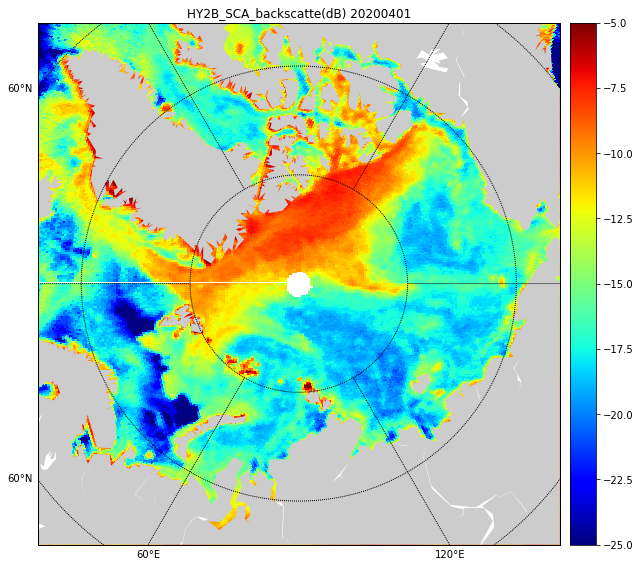

In [16]:
fig = plt.figure(figsize=(9, 9))
fig.add_subplot(111)
fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)
cb = hy_m.colorbar(location='right')
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title('HY2B_SCA_backscatte(dB) 20200401')
# you can get a high-resolution image as numpy array!!
plt.show()
plot_img_np = get_img_from_fig(fig)
# np.save((train_data_dir+ '\\npy\\HY2B_sca_sigmod0_'+str(name) + '.npy'), plot_img_np)
# print(name)

In [11]:
for files in file_list[2:]:
    name = files[0].split('_')[8].split('T')[0]
    value_array = np.empty(shape=(1702, 810,5))
    grid_array = np.zeros((hy_sca.nlat, hy_sca.nlon))
    grid_num_array = np.zeros((hy_sca.nlat, hy_sca.nlon))

    for file in files:
        with h5py.File(file, mode='r') as f:
            lat = f['cell_lat'][:]
            lon = f['cell_lon'][:]
            sigma0 = f['cell_sigma0'][:]

        sigma0 = sigma0*0.01

        lat[lat > 90] = 0 
        lon[lon > 360] = 0 
        sigma0[sigma0 < -300] = 0
#         projlats, projlons = transformer.transform(lat, lon)

        value_array[:,:,0] = lat
        value_array[:,:,1] = lon
        value_array[:,:,2],value_array[:,:,3] = transformer.transform(value_array[:,:,0], value_array[:,:,1])
        value_array[:,:,4] = sigma0
    #     value_array[:,:,4][value_array[:,:,4] < -300] = np.nan

        x = (value_array[:,:,2] / hy_sca.resolution).astype(np.int)
        y = (value_array[:,:,3] / hy_sca.resolution).astype(np.int)
        grid_array[y,x] += value_array[:,:,4]
        grid_num_array[y,x] += 1
        
    grid_array = grid_array / grid_num_array
    x_map, y_map = hy_sca.get_map_grid(transformer_back)

    fig = draw_sigmod_0(x_map, y_map, grid_array,train_data_dir + '\\pic\\HY2B_sca_sigmod0_' + str(name) + '.png')
    plot_img_np = get_img_from_fig(fig)
    np.save((train_data_dir+ '\\npy\\HY2B_sca_sigmod0_'+str(name) + '.npy'), plot_img_np)
    print(name)

<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200402


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200403


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200404


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200405


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200406


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200407


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200408


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200409


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200410


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200411


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200412


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200413


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200414


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200415


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200416


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200417


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200418


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200419


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200420


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200421


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200422


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200423


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200424


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200425


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200426


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200427


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200428


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200429


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200430


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200501


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200502


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200503


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200504


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200505


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200506


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200507


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200508


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200509


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200510


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200511


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200512


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200513


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200514


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200515


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200516


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200517


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200518


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200519


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200520


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200521


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200522


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200523


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200524


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200525


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200526


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200527


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200528


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200529


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200530


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200531


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200601


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200602


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200603


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200604


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200605


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200606


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200607


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200608


<ipython-input-11-454765c467b6>:31: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-dc6189161d11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200609


KeyboardInterrupt: 

    
    fig = draw_sigmod_0(x_map, y_map, grid_array)
    plot_img_np = get_img_from_fig(fig)

    name = files[6].split('_')[8].split('T')[0]

    np.savez((r'.\\npy\\sigmod0_'+ str(name) + '.npz'), plot_img_np)
